Testing Mushi
==

Here's a notebook for playing with the `mushi` module

API documentation can be viewed with
```python
help(PiecewiseConstantHistory)
help(JointHistory)
help(SFS)
```

In [1]:
%matplotlib notebook
import mushi
from mushi import PiecewiseConstantHistory, JointHistory, SFS
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit
import time

### Demographic history $\eta(t)$ and mutation rate history $\mu(t)$

In [2]:
t = np.logspace(-1, 4, 200)

y = 2000 * np.ones(len(t) + 1)
y[:-1] += np.exp(- .015 * (t - 600))
η = PiecewiseConstantHistory(t, y)

z_flat = np.ones(len(t) + 1)
z_pulse = np.ones(len(t) + 1)
z_pulse[1:] += expit(.05 * (t - 200)) - 1.5 * expit(.05 * (t - 1000))
μ_TCC = PiecewiseConstantHistory(t, 10 * z_pulse)
μ_other = PiecewiseConstantHistory(t, 10 * z_flat)

history_TCC = JointHistory(η, μ_TCC)
history_other = JointHistory(η, μ_other)

fig = history_TCC.plot(label='TCC>TTC')
history_other.plot(fig=fig, label='other')
plt.show()

/Users/williamdewitt/Applications/miniconda2/envs/mushi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


<IPython.core.display.Javascript object>

### SFS

In [3]:
tic = time.time()
n = 200
sfs_TCC = SFS(n)
sfs_other = SFS(n)
sfs_TCC.simulate(history_TCC)
sfs_other.simulate(history_other)
toc = time.time()
print(toc - tic)

2.0620951652526855


### Invert the `TCC>TTC` SFS conditioned on $\eta(t)$ to get $\mu(t)$

elapsed time 3.71


<IPython.core.display.Javascript object>


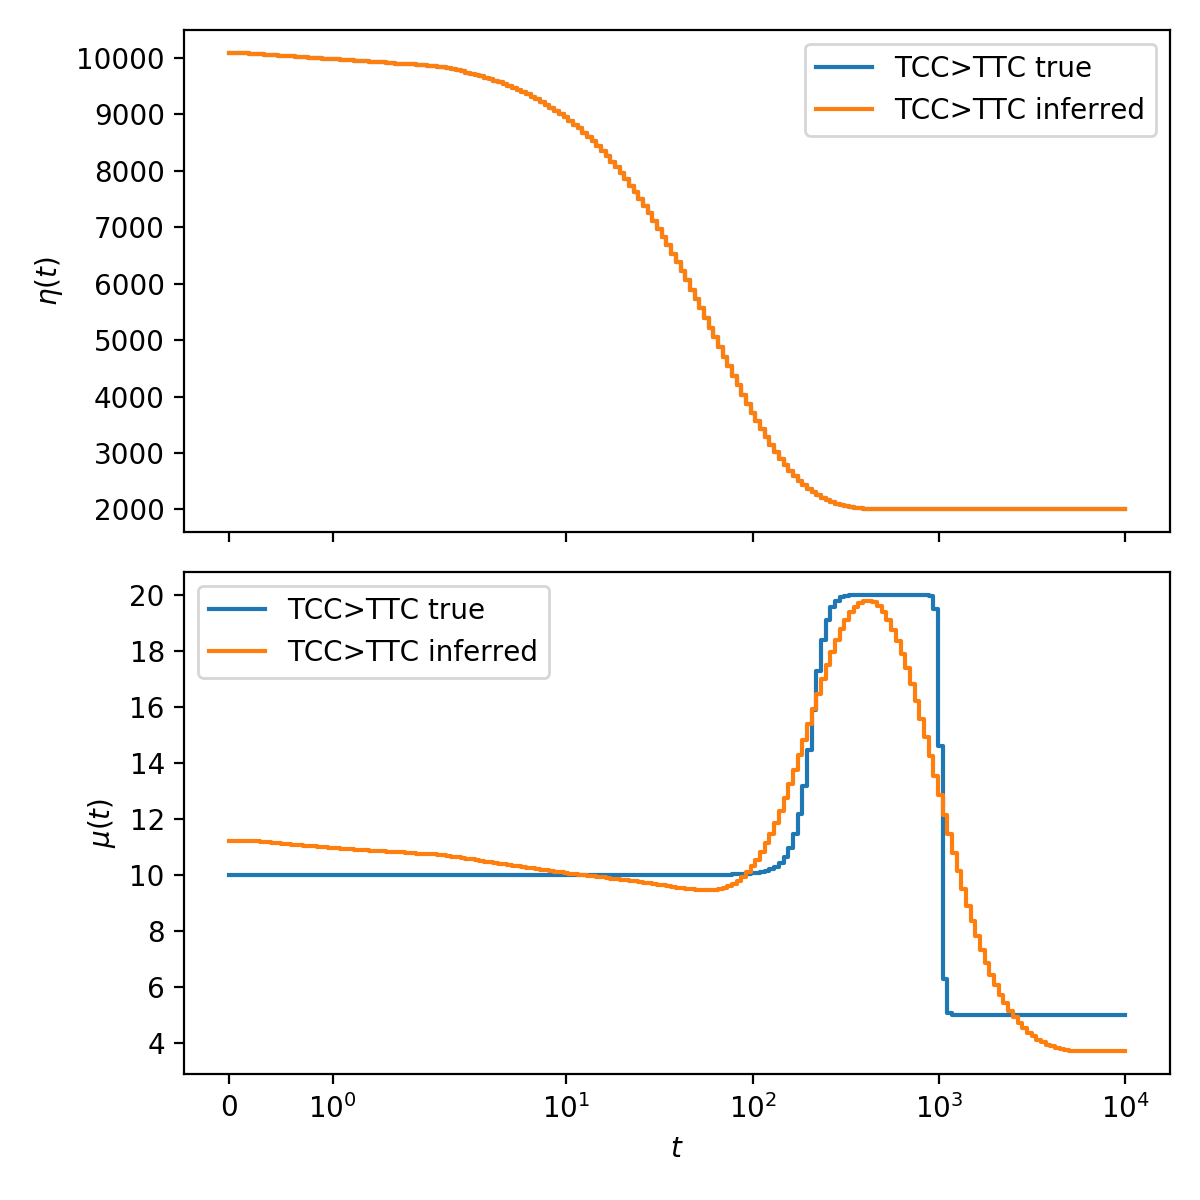

<IPython.core.display.Javascript object>


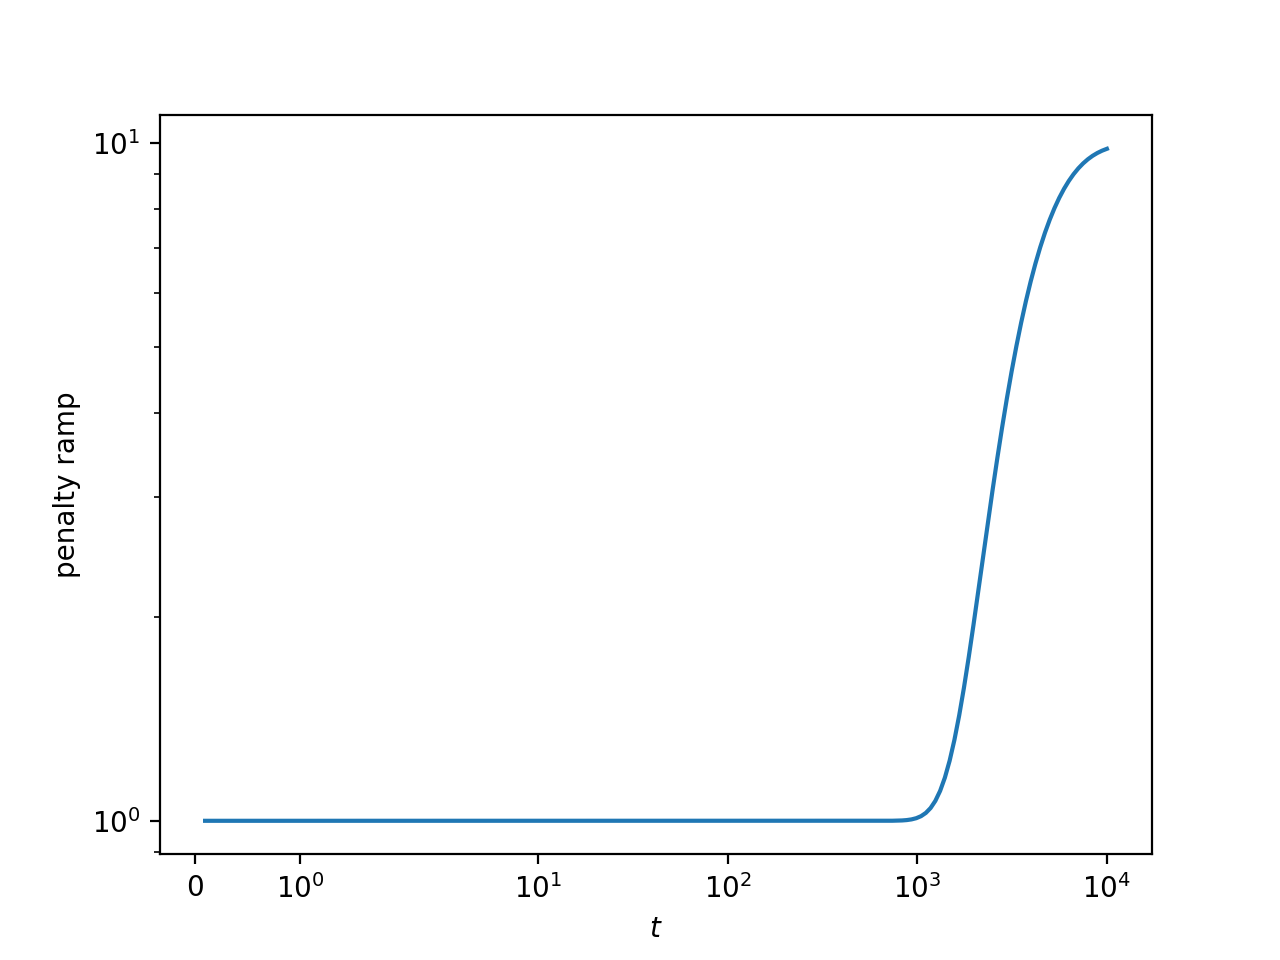

<IPython.core.display.Javascript object>


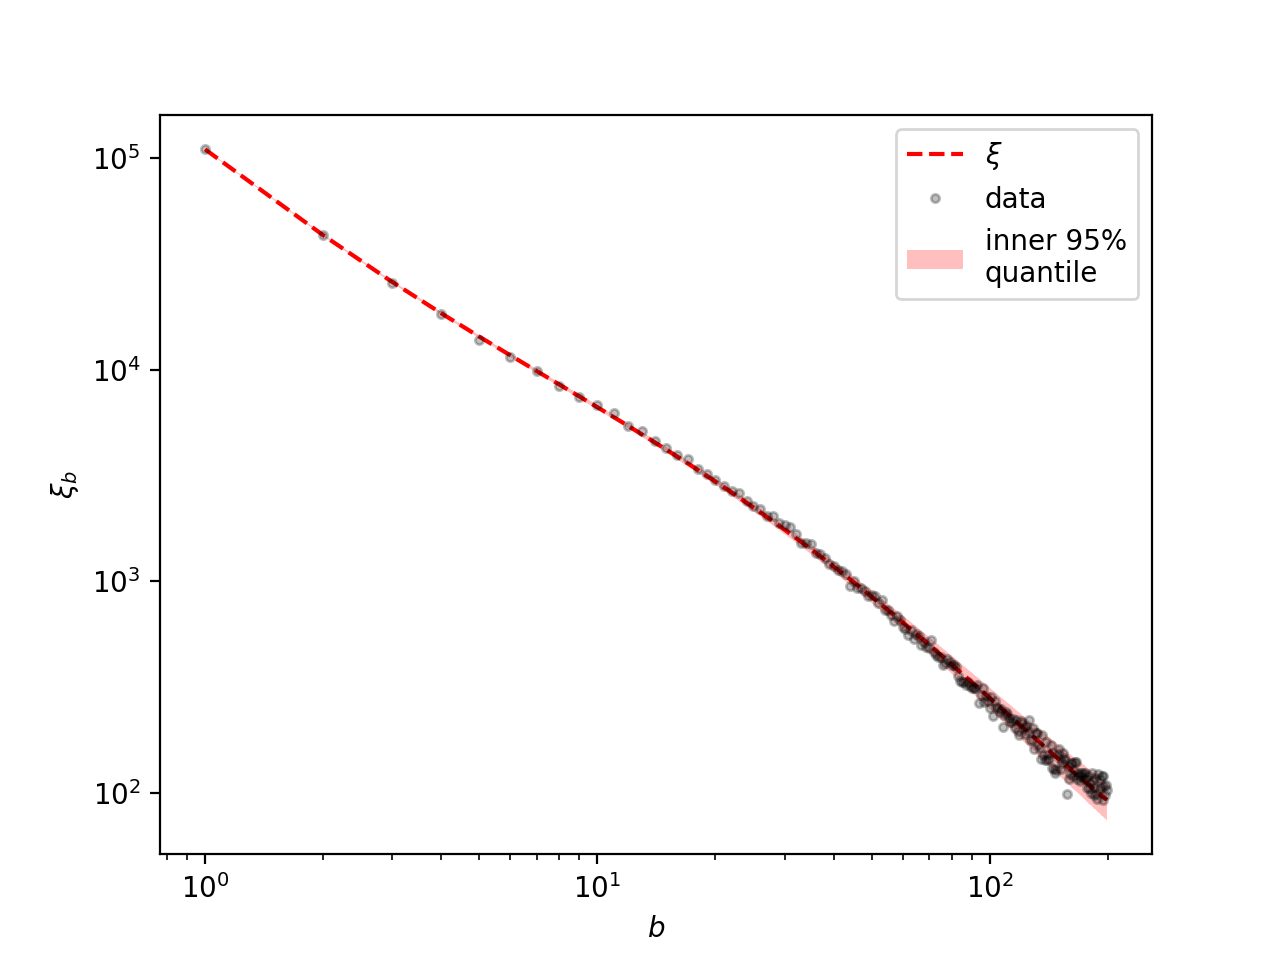

In [5]:
λ_η = 1e-1
λ_μ = 1e-1
α = 0.01
h = 1e1 # 1 for no ramp
s_η = 1e1
s_μ = 1e-2
steps = 1000

tic = time.time()
# history_inferred = sfs_TCC.infer_η(μ_TCC, λ=λ_η, α=α, s=s_η, steps=steps)
history_inferred = sfs_TCC.infer_μ(η, λ=λ_μ, α=α, h=h, s=s_μ, steps=steps)
toc = time.time()
print(f'elapsed time {toc - tic:.2f}')

fig = history_TCC.plot(label='TCC>TTC true')
history_inferred.plot(fig=fig, label='TCC>TTC inferred')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(η.change_points, sfs_TCC.w(history_inferred.η, h=h))
plt.xlabel('$t$')
plt.xscale('symlog')
plt.yscale('log')
plt.ylabel('penalty ramp')
plt.show()

plt.figure()
sfs_TCC.plot(history_inferred)
plt.show()

In [ ]:
sfs_TCC.ℓ(JointHistory(η, μ_TCC))